# Modelo preditivo preço do petróleo Brent

O objetivo deste notebook é avaliar o histórico de preço do petróleo Brent e treinar um modelo que realize a predição dos valores futuros

Os dados foram coletados diretamente do [IPEA](http://www.ipeadate.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view)

## Import das libs + Configs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pylab import rcParams
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, WindowAverage
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

C:\Users\mayke\anaconda3\envs\oil-price\lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
sns.set_style("darkgrid")

## Import dos dados

In [4]:
file = 'C:\\Users\\mayke\\Documents\\Cursos\\Fiap\\fiap\\tech-challenge\\fase-4\\ipea\\prod_data\\oil_price_hist.csv'
oil = pd.read_csv(file,parse_dates=['date'])
oil.head()

,date,oil_price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## Validação e tratamento Inicial dateFrame

In [5]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11078 entries, 0 to 11077
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       11078 non-null  datetime64[ns]
 1   oil_price  11078 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 173.2 KB


In [6]:
#mudando o índice para a date
oil.index = oil.date

In [7]:
oil = oil[['oil_price']]

In [8]:
oil.head()

,oil_price
date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [9]:
#renomenado colunas
oil.rename(columns={'oil_price':'Valor'},inplace=True)
oil.index.rename('DS',inplace=True)

In [10]:
oil.head()

,Valor
DS,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [11]:
print('Range de dates da base:')
print(oil.index.min())
print(oil.index.max())

Range de dates da base:
1987-05-20 00:00:00
2024-01-02 00:00:00


In [12]:
#ordenando o índice
oil.sort_index(inplace=True)
oil.head()

,Valor
DS,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


## EDA

Nesta etapa, iremos realizar algumas análises exploratórias para entender o comportamento histórico da variável dependente no decorrer do tempo

In [13]:
oil.describe()

,Valor
count,11078.000000
mean,52.763326
std,33.238025
min,9.100000
25%,20.400000
50%,47.815000
75%,75.597500
max,143.950000


Avaliando as estatísticas iniciais notamos que o preço sofreu uma grande alteração, tendo como menor histórico 9.1 e chegado até 143.9 em determinado momento. O desvio padrão é relativamento alto: 32.2

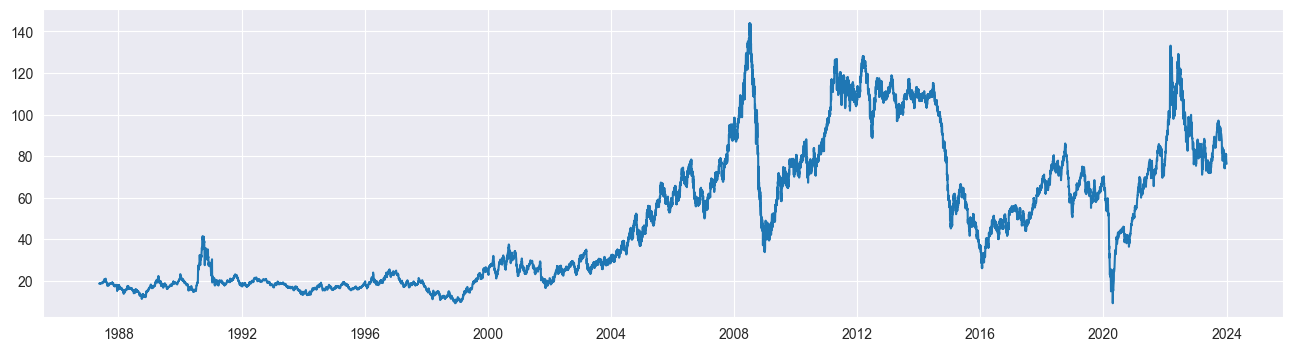

In [14]:
plt.figure(figsize=(16,4))
plt.plot(oil.index, oil.Valor)

Avaliando a serie histórica, notamos alguns picos e vales que são decorrentes de situações geopolíticas, crises econômicas, demanda global por energia e etc. Destacamos algumas:

### Guerra do Golfo

Em 1990, o Iraque invade o Kuwait – que participou na Guerra Irã-Iraque. Mais uma vez, uma das mais importantes regiões petrolíferas levanta preocupações no abastecimento do ocidente.

O preço do barril Brent, que no início da Guerra do Golfo, em 2 de agosto de 1990, era cotado a US$ 22,25, teve um aumento de cerca de 25% ao final do mês.

Já no mês seguinte, apresentava um aumento de 84,27%, chegando a ser cotado a US$ 41

[Fonte CNN](https://www.cnnbrasil.com.br/economia/guerra-e-petroleo-veja-reacoes-mais-drasticas-da-commodity-a-grandes-conflitos/#:~:text=Em%201990%2C%20o,pelo%20Ipeadata.)


### Ataques do 11 de Setembro

Em 11 setembro de 2001, o mundo assistia aos ataques contra o World Trade Center (WTC), que deixaram cerca de 3 mil mortes.

A estratégia dos EUA após esse impacto foi de estabelecer uma segurança ao país quanto às exportações de petróleo, sendo a commodity um motim dos conflitos e peça fundamental para as economias.

Segundo Ebraico, “além de derrubar o governo de Saddam Hussein (os EUA) e com isto eliminar um inimigo dos interesses americanos, a instauração de um governo pró-americano no Iraque garantiria um suprimento de petróleo a preços baixos”.

Enquanto isso, os preços do petróleo despencaram. No dia dos ataques, o barril Brent era cotado a US\\$ 29,12, diminuindo a US\\$ 25,57 uma semana depois. No final do mês de setembro, a queda foi de quase 25%

[Fonte CNN](https://www.cnnbrasil.com.br/economia/guerra-e-petroleo-veja-reacoes-mais-drasticas-da-commodity-a-grandes-conflitos/#:~:text=Ataques%20do%2011%20de%20setembro%20de%202001)

### Ano de 2008
O mercado não está pronto a esquecer 2008, "um dos anos mais difíceis e voláteis já vistos", destacou Peter Beutel, do gabinete americano Cameron Hanover.

Em 2 de janeiro, o barril passou a custar quase 100 dólares. Em seguida, teve quase seis meses de recordes quase diários, culminando a 147,50 dólares, em julho. Depois disso, os preços começaram a despencar mais rapidamente do que haviam subido, ficando a 39,35 dólares em Londres, no início de dezembro.

No primeiro semestre, uma soma de fatores levou os preços às alturas: tensões geopolíticas, do Irã à Nigéria passando pelo Paquistão; o equilíbrio tenso entre uma oferta limitada e uma demanda puxada pelos países emergentes; a conscientização de que as reservas são limitadas e de acesso cada vez mais difícil; uma febre dos fundos de investimento por matérias-primas.

Depois da falência do banco americano Lehman Brothers em setembro, esta lógica se inverte. Temendo a deflação, os investidores abandonam o petróleo, porque precisam urgentemente de liquidez. Ao mesmo tempo, o petróleo caro derruba o consumo de combustível dos países industrializados, os americanos deixam seus carros pesados na garagem. Assim, a demanda mundial caiu este ano, pela primeira vez em 25 anos, segundo as previsões da Agência Internacional de Energiaia.ro.

[Fonte G1](https://g1.globo.com/Noticias/Economia_Negocios/0,,MUL940136-9356,00-O+ANO+EM+QUE+O+PETROLEO+ENLOUQUECEU+O+MERCADO.html)

### Pandemia Covid-19

Devido a pandemia da covid-19, o barril do petróleo encerrou 2020 mais barato do que começou. A desvalorização do insumo foi uma das marcas de um ano difícil para o setor petroleiro. Levantamento divulgado pelo The Wall Street Journal mostra que o segmento sofreu depreciação de aproximadamente US$ 145 bilhões nos 3 primeiros trimestres de 2020, a maior na comparação com os setores financeiro, industrial, de telecomunicações e saúde, por exemplo.

A redução pela demanda em consequência do isolamento social –principal medida para evitar a disseminação do novo coronavírus– e seus impactos econômicos foram sentidos, principalmente, em fevereiro na Europa e em março nos Estados Unidos.

[Fonte CNN](https://www.cnnbrasil.com.br/economia/precos-do-petroleo-caem-e-brent-toca-us40-por-estoques-recorde-por-covid-19/)

[Fonte Poder 360](https://www.poder360.com.br/economia/pandemia-faz-preco-do-barril-de-petroleo-fechar-ano-20-mais-barato/)

[The Wall Street Journey](https://www.wsj.com/articles/2020-was-one-of-the-worst-ever-years-for-oil-write-downs-11609077600?mod=searchresults_pos10&page=1)


### Guerra Rússia x Ucrânia

Com guerra envolvendo a Rússia a cotação do barril Brent subiu rapidamente. No conflito com a Ucrânia, o crescimento do dia 24 de fevereiro a 3 de março de 2022 foi de 19,21%, com barris cotados em US$ 118,11.

Quando comparada a outros conflitos, o caso da Rússia tem um movimento mais direto, explica Gabriel. “A Rússia já é um grande produtor de petróleo, faz parte da OPEP+, e poderia ter mesmo, e foi o que aconteceu, sanções econômicas sendo aplicadas por parte do Ocidente”, diz.

Após cerca de 3 meses, os preços caíram. Isso porque, segundo Bassotto, as cadeias produtivas se realocam, e, quem antes comprava da Rússia, migrou para outro mercado ou conseguiu comprar mais barato do país, como Índia e China fizeram.

[Fonte CNN](https://www.cnnbrasil.com.br/economia/guerra-e-petroleo-veja-reacoes-mais-drasticas-da-commodity-a-grandes-conflitos/#:~:text=divulgados%20pelo%20Ipeadata.-,Guerra%20R%C3%BAssia%2DUcr%C3%A2nia,-Com%20guerra%20envolvendo)

### Decomposição da Série

Visando entender melhor os componentes da série temporal, iremos decompor a série para analisarmos a tendência, sazonalidade e os ruídos.

Como a análise da série como um todo não indicou claramente uma sazonalidade anual e ações são dados mais sensíveis e que sofrem rápidas mudanças por conta de qualquer movimentação ou notícia no mercado, iremos decompor a série utilizando um período de 5 dias para tentar identificar possível sazonalidade semanal (dias úteis)

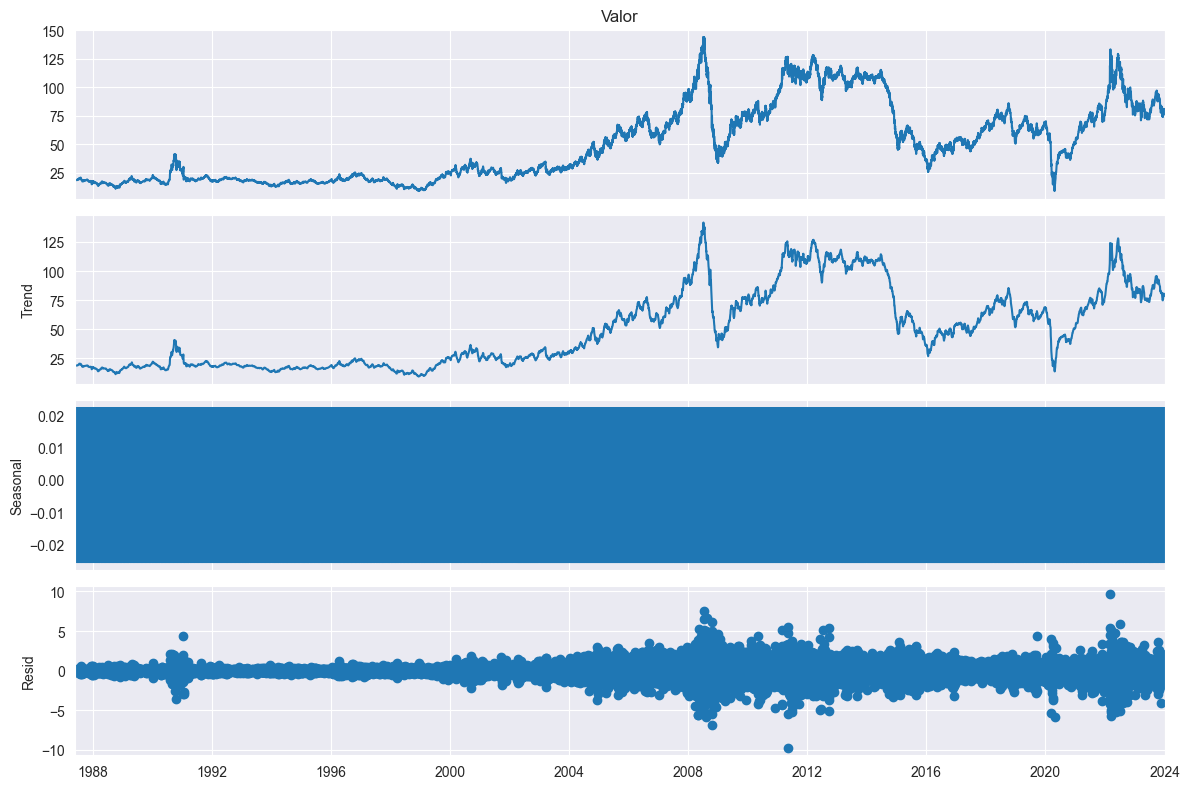

In [15]:
resultado = seasonal_decompose(oil['Valor'], period=5)

rcParams['figure.figsize'] = 12,8
resultado.plot()
plt.show()

- **Tendência:** analisando a tendência de forma isolada, notamos que a curva é muito semelhante a da base geral
- **Sazonalidade:** não identificamos uma forte influência do componente sazonal mesmo quando avaliamos o período de 5 dias (semanal): o maior valor dentro do componente de sazonalidade é de 0.02, o que é muito baixo quando comparamos com o valor total
- **Ruído:** esta série tem como característica um ruído baixo, chegando a no máximo 10

### Teste de estacionariedade

Muitos modelos tradicionais tem como premissa que a série temporal seja estacionária.

A estacionariedade indica uma série temporal que possui propriedades estatísticas razoavelmente  estáveis  ao  longo  do  tempo,  sobretudo  no  que  se  diz  a respeito à média e variância dos dados.

Porém, como fica difícil de determinarmos se a série é de fato estacionária apenas analisando o gráfico, iremos aplicar um teste estatístico chamado teste de Dickey-Fuller aumentado, também conhecido como ADF, que é um tipo de teste de hipótese. Este teste possui as seguintes hipóteses:

 H0 - Hipótese Nula (não é estacionária)

 H1 - Hipótese Alternativa (rejeição da hipótese nula)

 p -value = 0.05 (5%), então rejeitamos H0 com um nível de confiança de 95%


In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
#criando função para aplicação do teste e retorno das estatísticas
def adfuller_test(x):
  result = adfuller(x)
  print("Teste ADF")
  print(f"Teste Estatístico: {result[0]}")
  print(f"P-Value: {result[1]}")
  print("Valores críticos:")

  for key, value in result[4].items():
    print(f"\t{key}: {value}")

In [18]:
X = oil.Valor.values
adfuller_test(X)

Teste ADF
Teste Estatístico: -2.10554878574664
P-Value: 0.2422892686554186
Valores críticos:
	1%: -3.430942143789257
	5%: -2.8618016950601426
	10%: -2.566909295156636


**Resultado do Teste**:

Com o p_value de 0.25, com um nível de confiança de 95% nós falhamos ao rejeitar a hipótese nula de que a série não é estacionária.

Iremos aplicar algumas técnicas de transformação de série não estacionária em estacionária, pois alguns modelos tem como premissa que a base seja estacionária

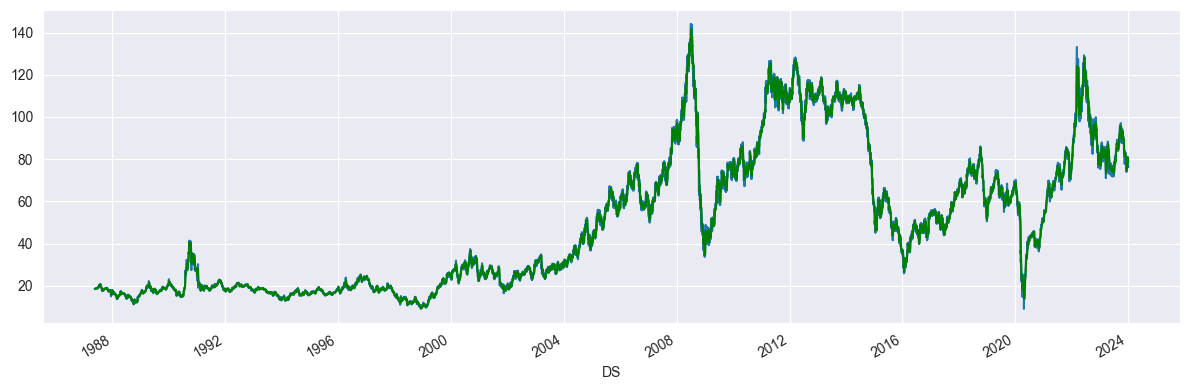

In [19]:
ma = oil.rolling(5).mean()

rcParams['figure.figsize'] = 12,4
f, ax = plt.subplots()
oil.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='g')

plt.tight_layout()

*Observando a média móvel de 5 dias, a variação nos dados ainda é alta. A escolha por este período de média móvel foi porque os dados de ação são bem voláteis, então analisar períodos mais longos podem não traduzir bem a realidade*

## Transformação da série para Estacionária

Existem algumas técnicas que podem ser aplicadas para a transformação da série não estacionária em estacionária.

As técnicas que vamos aplicar são:
- **Transformações  logarítmicas:** podemos fazer com que uma série temporal possa se tornar estacionária o suficiente realizando esses tipos de transformações na escala dos dados
- **Diferenciação da média móvel:** iremos calcular a diferença do dado em relação a média móvel
- **Diferenciação de período anterior:** iremos calcular a diferença do dado em relação ao período imediatamente anterior

#### Transformação logarítmica

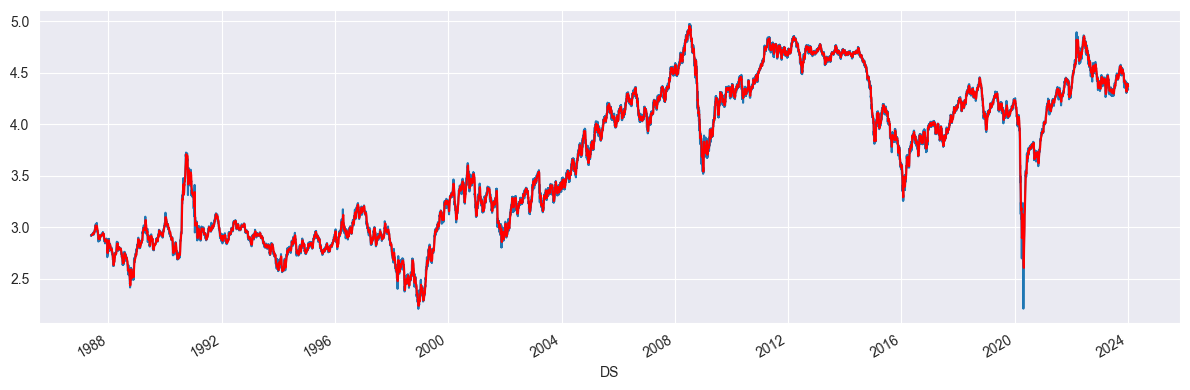

In [20]:
oil_log = np.log(oil)
ma_log = oil_log.rolling(5).mean()

f, ax = plt.subplots()
oil_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [21]:
X = oil_log.Valor.values
adfuller_test(X)

Teste ADF
Teste Estatístico: -1.9969263261525456
P-Value: 0.2879224221636695
Valores críticos:
	1%: -3.430941875812866
	5%: -2.861801576641083
	10%: -2.566909232122445


 **Resultado do Teste**:
Ao aplicarmos o log, a série se mantém não estacionária porém com um p-value levemente superior ao da base original

### Diferenciação da média móvel

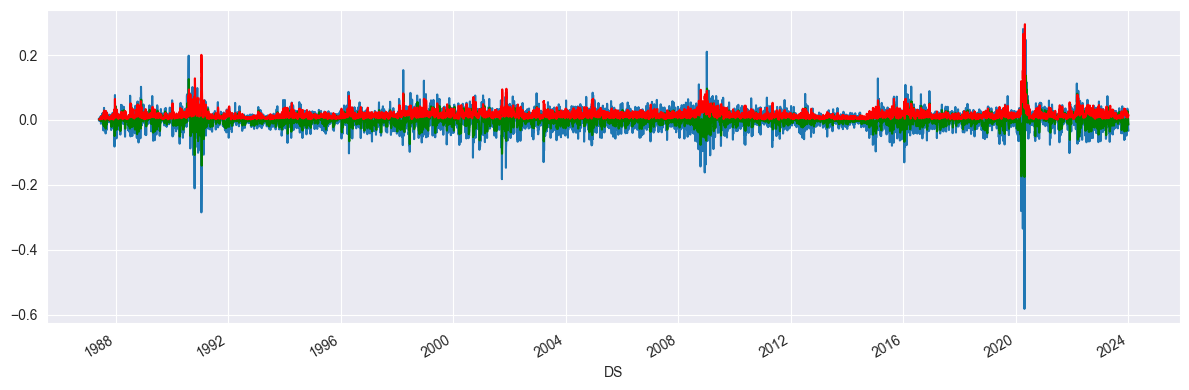

In [22]:
oil_s = (oil_log - ma_log).dropna()

ma_s = oil_s.rolling(5).mean()

std = oil_s.rolling(5).std()

f, ax = plt.subplots()
oil_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='g')
std.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [23]:
X = oil_s.Valor.values
adfuller_test(X)

Teste ADF
Teste Estatístico: -18.21669104321119
P-Value: 2.3853776136900203e-30
Valores críticos:
	1%: -3.430942090174568
	5%: -2.861801671367754
	10%: -2.566909282545232


**Resultado do Teste:** Ao aplicarmos a diferença da média móvel, a série se torna estacionária. Porém, ainda assim iremos aplicar outra técnica para avaliar se o p-value é modificado

### Diferenciação de período anterior

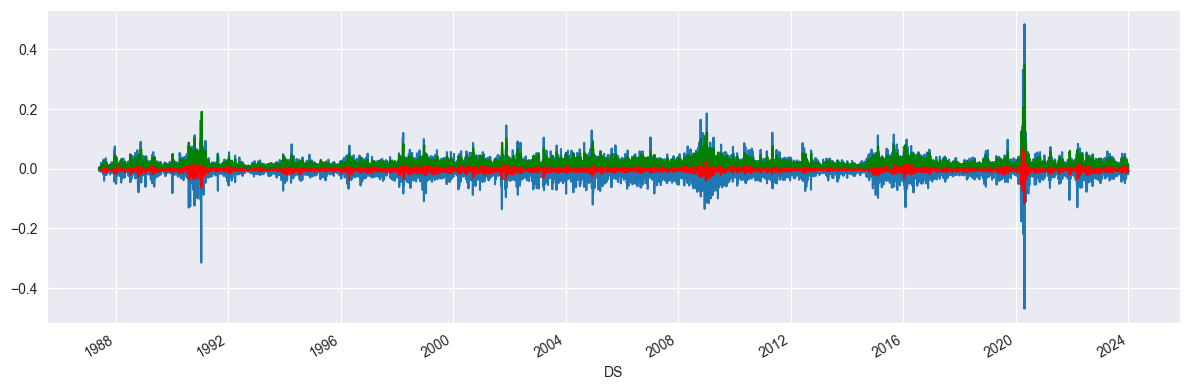

In [24]:
oil_diff = oil_s.diff(1)
ma_diff = oil_diff.rolling(5).mean()

std_diff = oil_diff.rolling(5).std()


f, ax = plt.subplots()
oil_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


oil_diff = oil_diff.dropna()

In [25]:
X = [float(x) for x in oil_diff.Valor.values]
adfuller_test(X)

Teste ADF
Teste Estatístico: -27.09799281309151
P-Value: 0.0
Valores críticos:
	1%: -3.430942787923712
	5%: -2.8618019797038166
	10%: -2.566909446671811


**Resultado do Teste:** Ao aplicarmos a diferença de período  anterior, a série se mantém estacionária porém com um p-value ainda menor

## Testes para Identificação do lag

Iremos avaliar a autocorrealção parcial e total para identificação de correlação com períodos anteriores nos dados

In [26]:
lag_acf = acf(oil_diff.dropna(), nlags=15)
lag_pacf = pacf(oil_diff.dropna(), nlags=15)

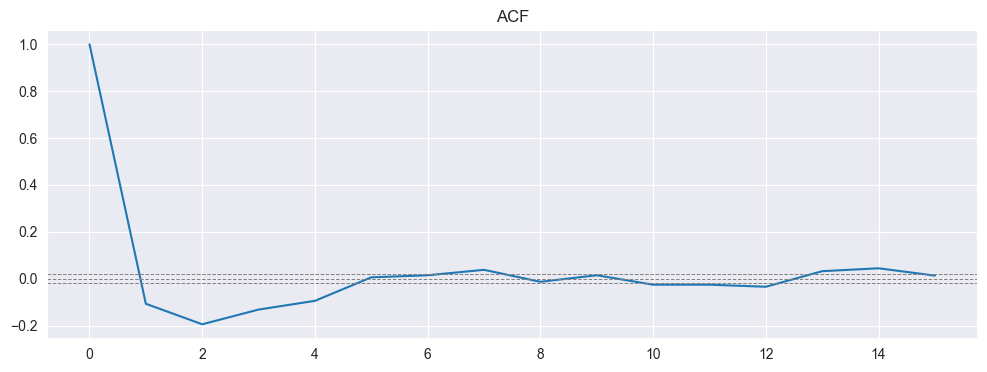

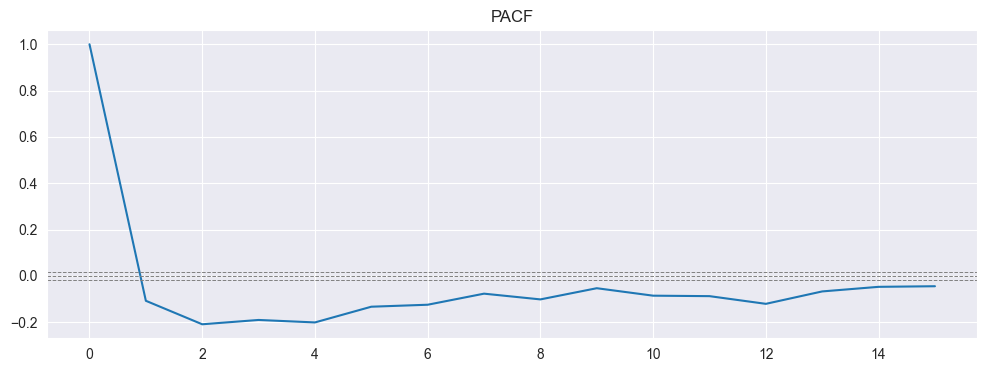

In [27]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(oil_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(oil_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(oil_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(oil_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

Para identificar o lag inicial, devemos considerar onde a linha toca o 0 no eixo y pela primeira vez, que neste caso é no lag de 1

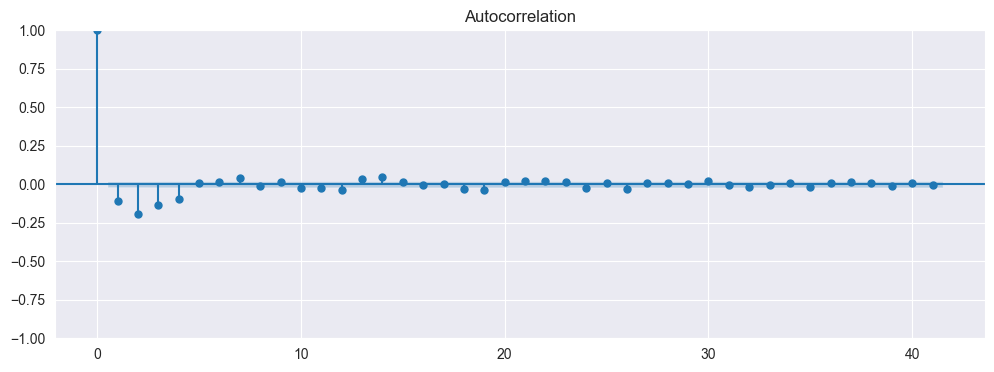

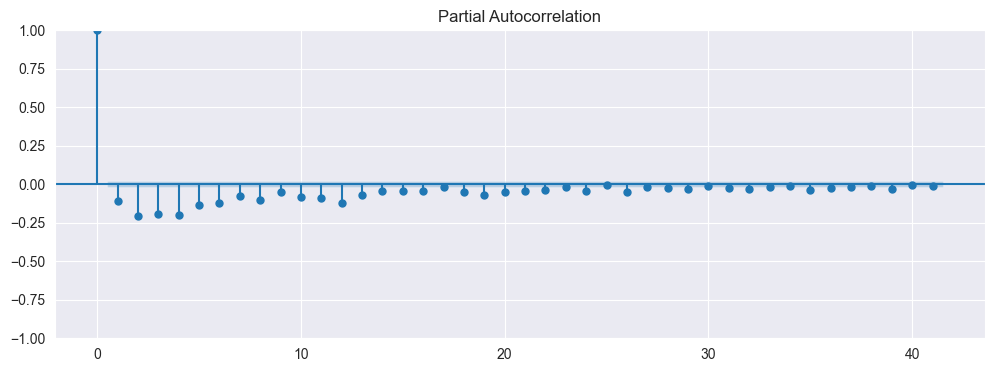

In [28]:
plot_acf(oil_diff.Valor)
plot_pacf(oil_diff.Valor)
plt.show()

Notamos que quase todos os lags possuem autocorrelação com significância estatística (pontos fora da área azul). Usando a combinação dos 2 gráficos, iremos iniciar com o lag de 1 que se mostrou um bom ponto de partida

**Separação da base de treino e teste**

Iremos manter quase toda a base como treino e separar 5 dias (1 semana completa) para realização dos testes. Como o mundo de ações é muito volátil, a ideia é prever um horizonte de apenas 5 dias para não aumentarmos demais a probabilidade de erro dos modelos

In [29]:
oil_diff_dt = oil_diff.reset_index()
oil_diff_dt.rename(columns={'DS':'ds','Valor':'y'},inplace=True)
oil_diff_dt['unique_id'] = 'oil'
oil_diff_dt.head()

,ds,y,unique_id
0,1987-05-27,-0.001289,oil
1,1987-05-28,-0.001619,oil
2,1987-05-29,-0.001399,oil
3,1987-06-01,0.003223,oil
4,1987-06-02,0.001071,oil


In [30]:
oil_diff_dt['ds'].max()

Timestamp('2024-01-02 00:00:00')

In [31]:
treino = oil_diff_dt.loc[oil_diff_dt['ds'] < '2023-12-18']
valid = oil_diff_dt.loc[(oil_diff_dt['ds'] >= '2023-12-18') & (oil_diff_dt['ds'] < '2023-12-26')]
h = valid['ds'].nunique()

In [32]:
treino.count()

ds           11063
y            11063
unique_id    11063
dtype: int64

In [33]:
valid.count()

ds           5
y            5
unique_id    5
dtype: int64

## Treinamento e avaliação dos modelos

In [36]:
#função para avaliar o modelo
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

### Modelo baseline

C:\Users\mayke\anaconda3\envs\oil-price\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 89.95%


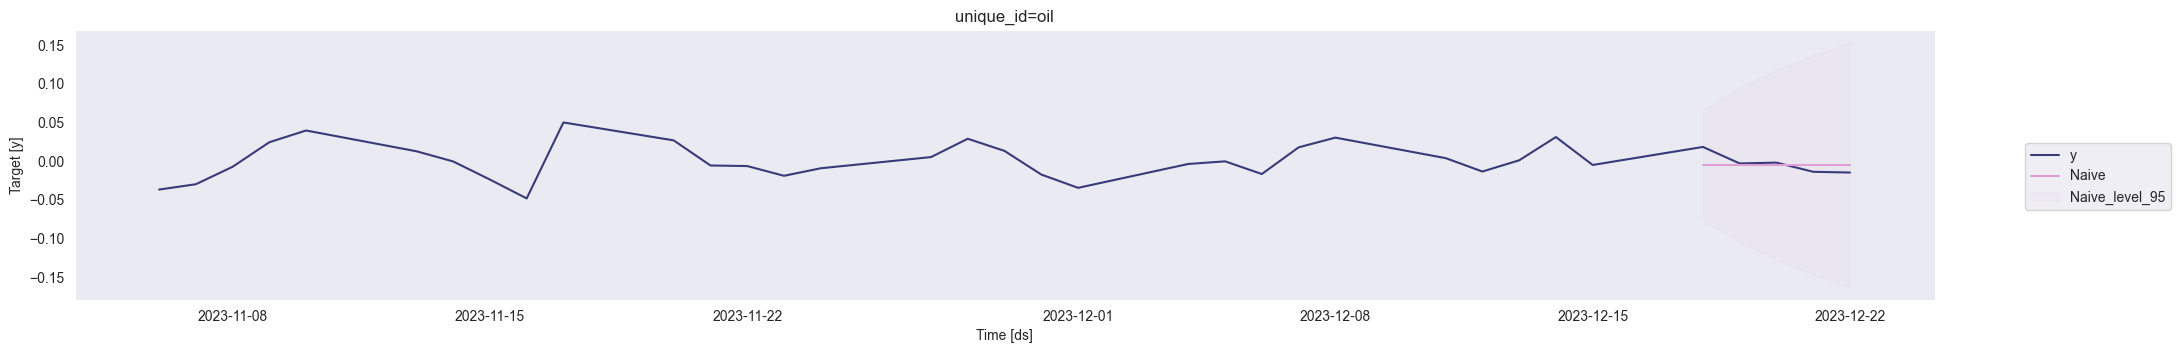

In [37]:
#instancia e treina modelo
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

#realiza predições no horizonte desejado
forecast_df = model.predict(h=h, level=[95])

#corrige a date setada automaticamente pelo modelo como final de semana
forecast_df["ds"] = forecast_df['ds'] + timedelta(days=2)

#recupera valor real de y
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model.plot(treino, forecast_df, level=[95], unique_ids=['oil'],engine ='matplotlib', max_insample_length=30)


O modelo de baseline está tendo dificuldades ao prever os dados. Tivemos um erro absoluto médio de 89.95%

### Modelo baseline com sazonalidade

C:\Users\mayke\anaconda3\envs\oil-price\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 158.23%


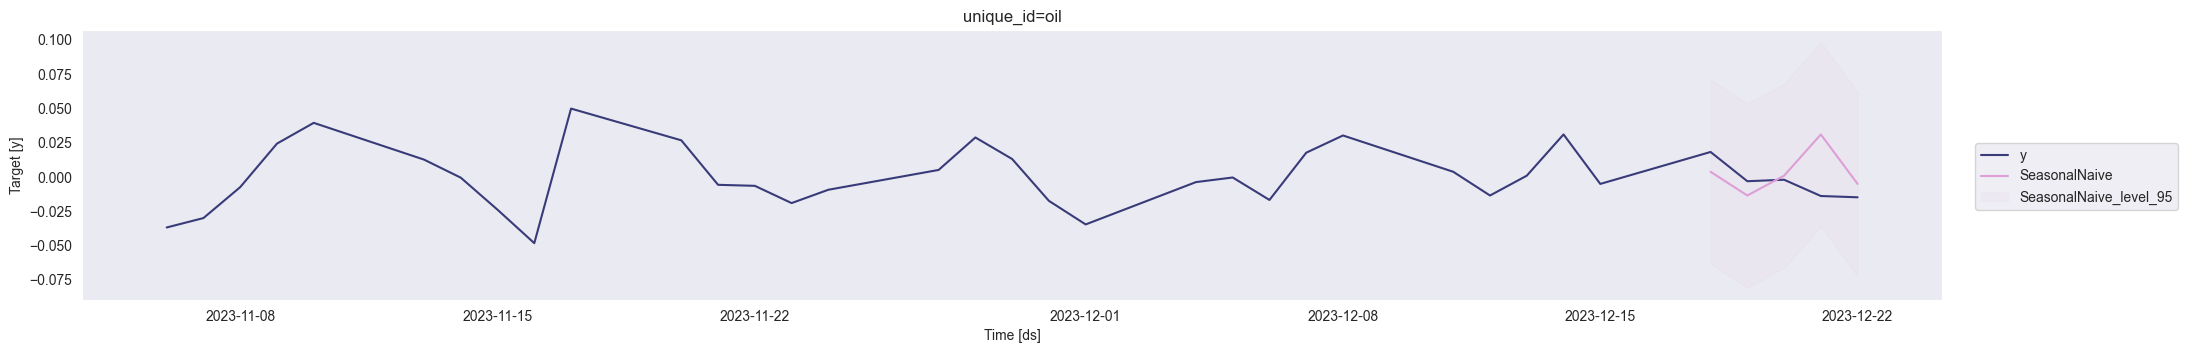

In [38]:
#instancia e treina modelo
model_s = StatsForecast(models=[SeasonalNaive(season_length=5)], freq='D', n_jobs=-1)
model_s.fit(treino)

#realiza predições no horizonte desejado
forecast_dfs = model_s.predict(h=h, level=[95])

#corrige a date setada automaticamente pelo modelo como final de semana
forecast_dfs["ds"] = forecast_dfs['ds'] + timedelta(days=2)

#recupera valor real de y
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape1:.2%}")

model_s.plot(treino, forecast_dfs, level=[95], unique_ids=['oil'],engine ='matplotlib', max_insample_length=30)


Considerando o modelo Naive sazonal o resultado o erro absoluto médio é pior: 158%. Isso reforça nossa hipótese de que a sazonalidade não tem muita influência sobre o dado

### ARIMA

WMAPE: 109.48%


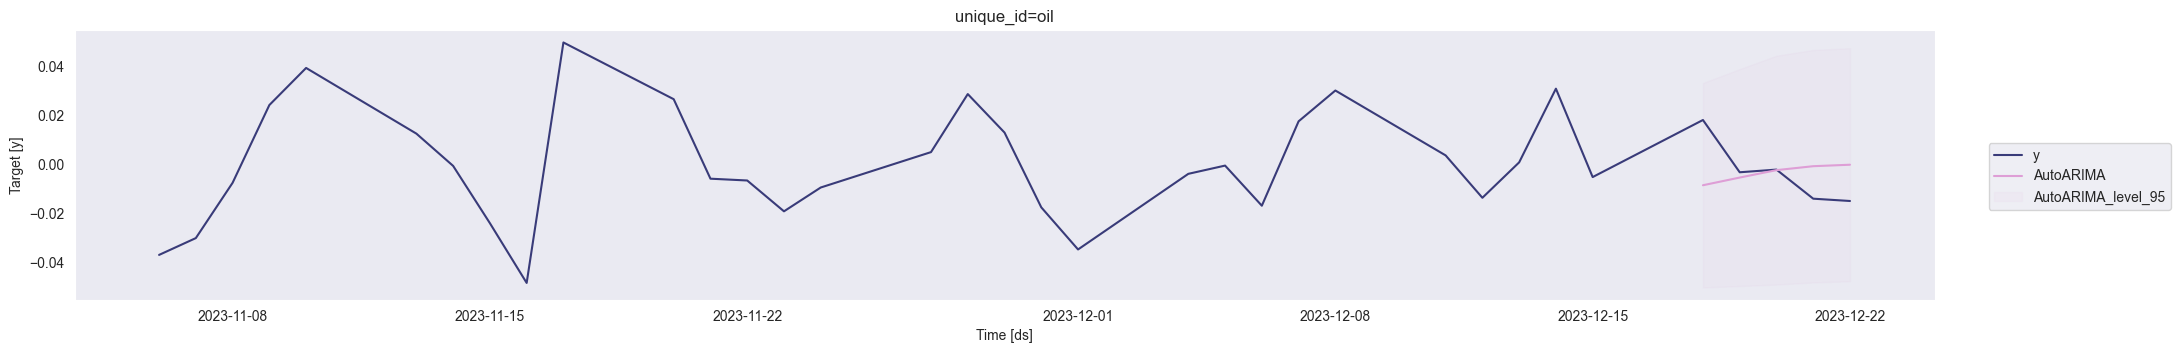

In [69]:
#instancia e treina modelo
model_a = StatsForecast(models=[AutoARIMA(
    d=1,
    start_p=1,
    max_p=12,
    start_q=2,
    max_q=12,
    seasonal=False,
    stationary=True,
    )], freq='D', n_jobs=-1)
model_a.fit(treino)

#realiza predições no horizonte desejado
forecast_dfa = model_a.predict(h=h, level=[95])

#corrige a date setada automaticamente pelo modelo como final de semana
forecast_dfa["ds"] = forecast_dfa['ds'] + timedelta(days=2)

#recupera valor real de y
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape1:.2%}")

model_a.plot(treino, forecast_dfa, level=[95], unique_ids=['oil'],engine ='matplotlib', max_insample_length=30)


O ARIMA também parece não conseguir prever bem, com um erro médio absoluto de 109%

### Prophet

In [40]:
oil_dt = oil.reset_index()
oil_dt.rename(columns={'DS':'ds','Valor':'y'},inplace=True)
oil_dt.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [41]:
treino_orig = oil_dt.loc[oil_dt['ds'] < '2023-12-18']
valid_orig = oil_dt.loc[(oil_dt['ds'] >= '2023-12-18') &  (oil_dt['ds'] < '2023-12-26')]
h_orig = valid_orig['ds'].nunique()

In [42]:
treino_orig.count()

ds    11068
y     11068
dtype: int64

In [43]:
valid_orig.count()

ds    5
y     5
dtype: int64

In [44]:
#future dates
future_dates = pd.DataFrame(pd.date_range('2023-12-18','2023-12-22', freq='D'))
future_dates.rename(columns={0:'ds'},inplace=True)
future_dates.head()

,ds
0,2023-12-18
1,2023-12-19
2,2023-12-20
3,2023-12-21
4,2023-12-22


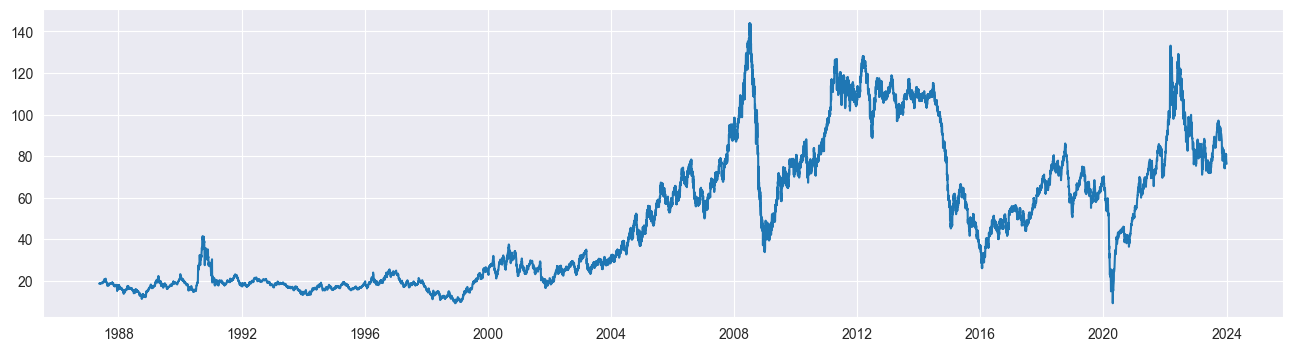

In [45]:
plt.figure(figsize=(16,4))
plt.plot(oil.index, oil.Valor)

In [112]:
m3_changepoints = (
    # guerra do golfo
    pd.date_range('1990-08-02', '1991-02-28', periods=15).date.tolist() +
    # 11 de setembro
    pd.date_range('2001-09-11', '2001-09-30', periods=15).date.tolist() +
    # ano de 2008 (primeiro recorte)
    pd.date_range('2008-01-01', '2008-07-31', periods=15).date.tolist() +
    # ano de 2008 (segundo recorte)
    pd.date_range('2008-08-01', '2008-12-31', periods=15).date.tolist() +
    # Pandemia covid-19
    pd.date_range('2020-03-11', '2020-04-01', periods=15).date.tolist() +
    # Guerra russia x ucrania
    pd.date_range('2022-02-24', '2022-04-01', periods=15).date.tolist()
)

In [129]:
model_pro = Prophet(
    weekly_seasonality=False,
    yearly_seasonality=False,
    daily_seasonality=False,
    changepoints=m3_changepoints,
    changepoint_prior_scale=1.0
    )
# Fit the model
model_pro.fit(treino_orig)

# Make predictions
forecast = model_pro.predict(future_dates)

19:48:30 - cmdstanpy - INFO - Chain [1] start processing
19:48:51 - cmdstanpy - INFO - Chain [1] done processing


Definição da escolha de hiperparametros:
- Removemos todas as sazonalidades do modelo, pois durante o processo de análise exploratória não identificamos nenhum componente sazonal
- Modelamos pontos específicos de mudança nas tendências da série temporal (informados anteriormente). Este parâmetro ajuda o modelo a entender pontos em que a tendência sofre influência por causa de eventos específicos. [Referência aqui](https://facebook.github.io/prophet/docs/handling_shocks.html#sense-checking-the-trend:~:text=seems%20fairly%20reasonable.-,Sense%20checking%20the%20trend,-In%20an%20environment)

In [130]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2023-12-18,80.751898,60.224469,101.345586
1,2023-12-19,80.729980,60.503891,101.047511
2,2023-12-20,80.708062,59.609650,99.139502
3,2023-12-21,80.686144,60.846225,101.635219
4,2023-12-22,80.664226,60.234033,101.214373


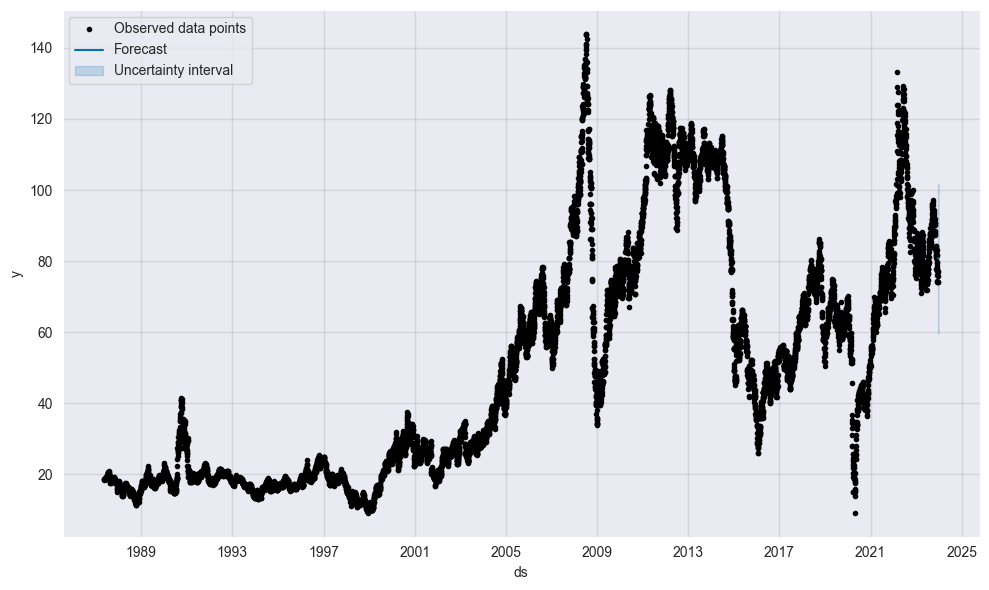

In [131]:
fig1 = model_pro.plot(forecast,include_legend=True)

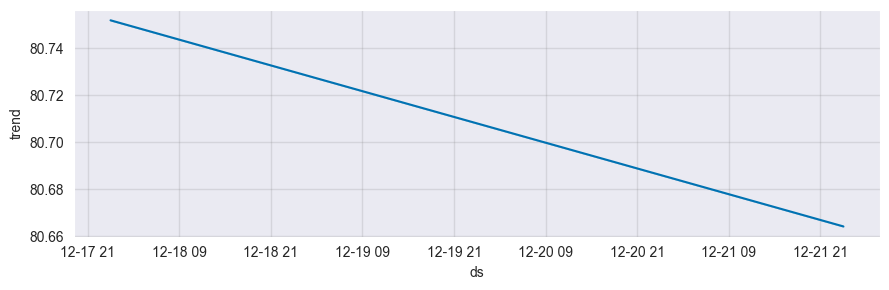

In [132]:
fig2 = model_pro.plot_components(forecast)

In [133]:
from prophet.plot import plot_plotly, plot_components_plotly

In [134]:
help(plot_plotly)

Help on function plot_plotly in module prophet.plot:

plot_plotly(m, fcst, uncertainty=True, plot_cap=True, trend=False, changepoints=False, changepoints_threshold=0.01, xlabel='ds', ylabel='y', figsize=(900, 600))
    Plot the Prophet forecast with Plotly offline.
    
    Plotting in Jupyter Notebook requires initializing plotly.offline.init_notebook_mode():
    >>> import plotly.offline as py
    >>> py.init_notebook_mode()
    Then the figure can be displayed using plotly.offline.iplot(...):
    >>> fig = plot_plotly(m, fcst)
    >>> py.iplot(fig)
    see https://plot.ly/python/offline/ for details
    
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    trend: Optional boolean to plot trend
    changepoints: Optional boolean to plot changepoints
    changepoint

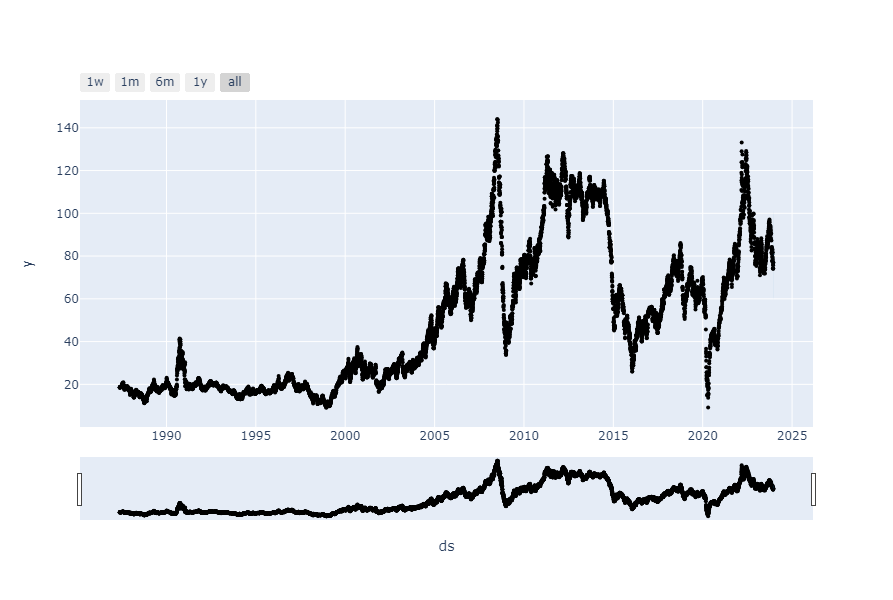

In [135]:
plot_plotly(model_pro, forecast)

In [136]:
#recupera valor real de y
forecast_with_real = forecast.merge(valid_orig[['ds','y']], on=['ds'], how='left')
forecast_with_real.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2023-12-18,80.751898,60.224469,101.345586,80.751898,80.751898,0.0,0.0,0.0,0.0,0.0,0.0,80.751898,78.89
1,2023-12-19,80.729980,60.503891,101.047511,80.729980,80.729980,0.0,0.0,0.0,0.0,0.0,0.0,80.729980,79.82
2,2023-12-20,80.708062,59.609650,99.139502,80.708062,80.708062,0.0,0.0,0.0,0.0,0.0,0.0,80.708062,81.10
3,2023-12-21,80.686144,60.846225,101.635219,80.686144,80.686144,0.0,0.0,0.0,0.0,0.0,0.0,80.686144,80.73
4,2023-12-22,80.664226,60.234033,101.214373,80.664226,80.664226,0.0,0.0,0.0,0.0,0.0,0.0,80.664226,80.23


In [137]:
treino_orig.set_index('ds')

,y
ds,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2023-12-11,75.75
2023-12-12,74.11
2023-12-13,74.14


In [138]:
treino_plot = treino_orig.set_index('ds')
treino_plot = treino_plot.loc[treino_plot.index > '2023-08-01']
treino_plot.head()

,y
ds,
2023-08-02,84.01
2023-08-03,86.19
2023-08-04,87.38
2023-08-07,86.47
2023-08-08,88.00


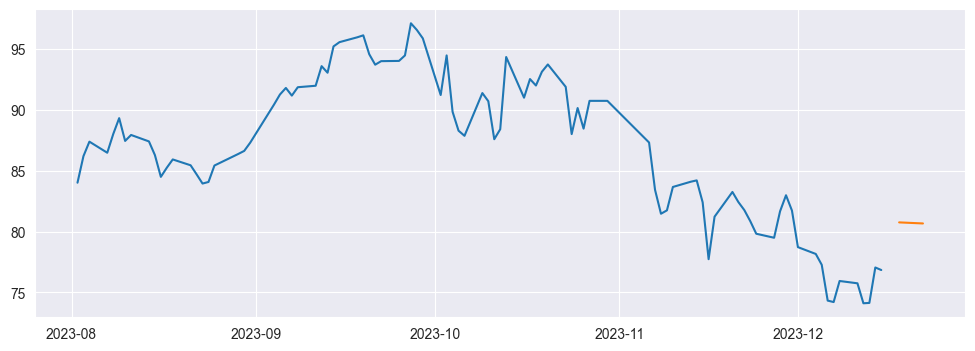

In [139]:
#plotando previsões
plt.plot(treino_plot)
plt.plot(forecast_with_real.set_index('ds')['yhat'])
#plt.plot(sarima_test.predict(start='2023-01-01',end='2023-12-01'))

Text(0, 0.5, 'Preço do petróleo Brent')

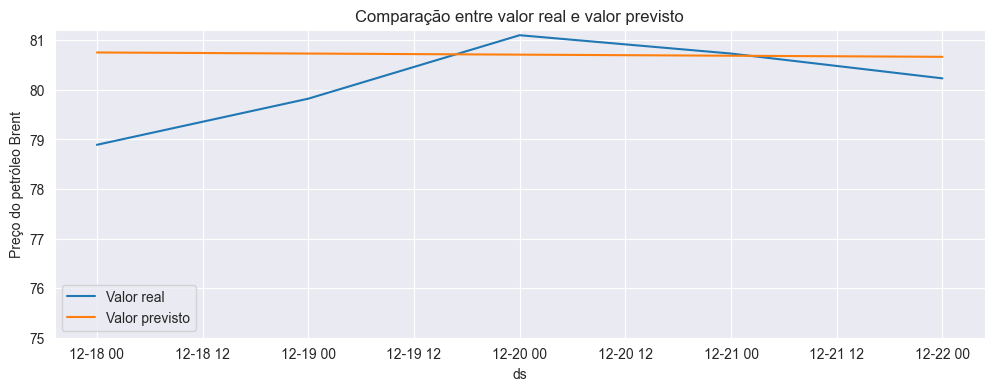

In [156]:
ax = sns.lineplot(data=forecast_with_real,x='ds',y='y',label='Valor real')
sns.lineplot(data=forecast_with_real,x='ds',y='yhat',ax=ax,label='Valor previsto')
plt.ylim(75)
plt.title('Comparação entre valor real e valor previsto')
plt.ylabel('Preço do petróleo Brent')

In [141]:
wmape1 = wmape(forecast_with_real['y'].values, forecast_with_real['yhat'].values)
print(f"WMAPE: {wmape1:.2%}")

WMAPE: 0.91%


## Conclusões

- Os modelos mais tradicionais como Naive e ARIMA não conseguiram um bom resultado na predição dos preços do petróleo Brent. Nossa hipótese é que como os preços são bem voláteis (muita variação no dado), estes modelos não conseguem capturar um padrão de tendência e sazonalidade e com isso tem resultados baixos
- Com o Prophet, conseguimos atingir um baixo percentual de erro médio absoluto (0,91%). Mapeamos alguns acontecimentos históricos e passamos como um hiper parâmetro do modelo para auxiliar na redução do erro

## Export do modelo
Iremos utilizar a lib joblib para realizar a extração do modelo, que será aplicado em produção posteriormente

In [64]:
import joblib

In [159]:
joblib.dump(model_pro, 'prophet_time_series.joblib')

['prophet_time_series.joblib']